In [ ]:
import pandas as pd
import datetime as dt
import csv
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
df = pd.read_csv('2022-07.csv',sep = ';', encoding = 'latin1')[:-1]
df = df[['Priorité','Provenance',"Date d'injection","Temps écoulé"]]
df = df.rename(columns = {'Priorité':'PRIO','Provenance':'ETAGE',"Date d'injection":'ENVOI',"Temps écoulé":'DELAI'})
df.ENVOI = pd.to_datetime(df.ENVOI,format = '%Y-%m-%d %H:%M')
df['TIME'] = df.ENVOI.dt.time
df['DATE'] = df.ENVOI.dt.date

#cleaning PRIO
df.PRIO = df.PRIO.str.split('-').str[0]
prio_change = {"RÉG":"Regulier",
               "ATB":"Antibio",
               "STAT":"Stat",
               "CORREC":"Correction",
               "URGENCE":"Urgence",
               " ATTENTE":"Attente",
               "SINT":"Soins"}
df.PRIO = df.PRIO.map(prio_change).fillna(df.PRIO)

#cleaning ETAGE
etages_change = {"HND-CLINIQUE CHX RÉGULIÈRE":"HND-CLINIQUE_CHX RÉGULIÈRE",
                 "HND-STMURÉGULIÈRE":"HND-STMU RÉGULIÈRE",
                 "HND-CLINIQUE CHX STAT":"HND-CLINIQUE-CHX STAT",
                 "HND- Fax pharmacie 2":"HND-Fax_pharmacie_2",
                 "HND- Profil du patient":"HND-Profil_du_patient",
                 "HND-ENDO- DIGESTIVE ANTIBIOTIQUES": "HND-ENDO-DIGESTIVE ANTIBIOTIQUES",
                 "HND-ENDO- DIGESTIVE ANTIBIOTIQUES": "HND-ENDO-DIGESTIVE ANTIBIOTIQUES",
                 "HND-ENDO- URO ANTIBIOTIQUES":"HND-ENDO-URO ANTIBIOTIQUES",
                 "HND-CLINIQUE CHX ANTIBIO":"HND-CLINIQUE-CHX ANTIBIO",
                 "HND-clin ext spec RÉGULIÈRE":"HND-clin_ext_spec RÉGULIÈRE",
                 "HND-clin ext spec STAT":"HND-clin_ext_spec STAT",
                 "HND-clin ext spec ANTIBIOTIQUES":"HND-clin_ext_spec ANTIBIOTIQUES",
                 "HND-accueil clinique RÉGULIÈRE": "HND-accueil-clinique RÉGULIÈRE",
                 "HND- UPSY ANTIBIOTIQUES" : "HND-UPSY ANTIBIOTIQUES",
                 "HND- UHBP ANTIBIOTIQUES" : "HND-UHBP ANTIBIOTIQUES",
                 "HND- PHCIE2 STAT": "HND-PHCIE2 STAT",
                 "HND- PHCIE1 STAT": "HND-PHCIE1 STAT"}
df.ETAGE = df.ETAGE.map(etages_change).fillna(df.ETAGE)
df.ETAGE = df.ETAGE.str.split('HND-').str[1].str.split(' ').str[0]
drop = ["STMU","PI","PHCIE2","PHCIE1","ORTHO","ORL","ENDO-URO","ENDO-DIGESTIVE","CRAN","CLINIQUE_CHX",
       "CLINIQUE-CHX",'clin_ext_spec','accueil-clinique','Profil_du_patient','Fax_pharmacie_2']
df.drop(df[df.ETAGE.isin(drop)].index, inplace = True)

nb_corrections = len(df[df.PRIO == 'Correction'])
nb_rx_total = len(df)

#filtrer pour n'avoir que les rx dans les heures d'ouverture selon la sem ou la fds
mask_sem = (df.ENVOI.dt.weekday.isin([0,1,2,3,4])) & (df.TIME > dt.time(7,30)) & (df.TIME < dt.time(19,0))
mask_fds = (df.ENVOI.dt.weekday.isin([5,6])) & (df.TIME > dt.time(8,0)) & (df.TIME < dt.time(17,0))
df = df[(mask_sem) | (mask_fds)]

nb_rx_ouverture = len(df)

#complicated way of changing delai to int but way faster than a for loop
df.DELAI = df.DELAI.str.split(' ').str[0].str[:-1].astype(int)*60 + df.DELAI.str.split(' ').str[1].str[:-1].astype(int)

#filtering for under 4 hours
cutoff  = 240
df = df[df.DELAI < cutoff]

moyenne = {}
for prio in prio_change.values():
    moyenne[prio] = round(df[df.PRIO == prio].DELAI.mean(),2)

mediane = {}
for prio in prio_change.values():
    mediane[prio] = round(df[df.PRIO == prio].DELAI.median(),2)

month_length = len(df.DATE.unique())

#storing data for csv write as date,periode,nb_rx,%correction,Global,Régulier,Antibio,Stat,Correction,Urgence,Attente,Soins,min,quart25,median,quart75,max
to_store = [df.DATE.min().strftime('%Y-%m'),month_length,nb_rx_total,round(nb_corrections*100/nb_rx_total,2),round(df.DELAI.mean(),2)]

for value in moyenne.values():
    to_store.append(round(value,2))

iqr = df.DELAI.quantile(0.75) - df.DELAI.quantile(0.25)

q1 = max(df.DELAI.quantile(0.25)-1.5*iqr,df.DELAI.quantile(0))
to_store.append(q1)
q2 = df.DELAI.quantile(0.25)
to_store.append(q2)
q3 = df.DELAI.quantile(0.5)
to_store.append(q3)
q4 = df.DELAI.quantile(0.75)
to_store.append(q4)
q5 = min(df.DELAI.quantile(0.75)+1.5*iqr,df.DELAI.quantile(1))
to_store.append(q5)

dates = []
#prevent writing to csv if date already in it
with open('data.csv',newline = '', encoding= 'latin1') as file:
    reader = csv.reader(file, delimiter=';')
    for row in reader:
        dates.append(row[0])

with open('data.csv','a',newline = '', encoding= 'latin1') as file:
    writer = csv.writer(file, delimiter = ';')
    if to_store[0] not in dates:
        writer.writerow(to_store)

graph = pd.read_csv('data.csv', sep = ';', encoding='latin1')
box = graph[['date','min','quart25','median','quart75','max']].set_index('date')

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


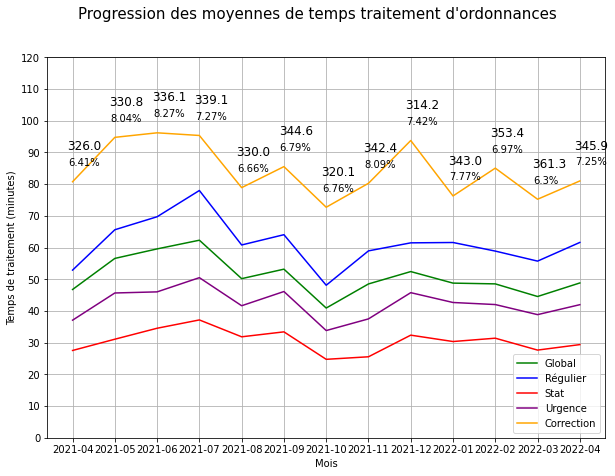

À noter:
Les chiffres au-dessus des courbes représentent les moyennes quotidiennes de feuilles reçues et le pourcentages de feuilles retournées en correction.




In [ ]:
fig1 = plt.figure(figsize = (10,7))

plt.plot(graph['date'],graph['Global'],label='Global', color = 'green');
plt.plot(graph['date'],graph['Regulier'],label='Régulier', color = 'blue');
plt.plot(graph['date'],graph['Stat'],label='Stat', color = 'red');
plt.plot(graph['date'],graph['Urgence'],label='Urgence', color = 'purple');
plt.plot(graph['date'],graph['Correction'],label='Correction', color = 'orange');

for i,value in enumerate(graph.nb_rx):
    rx = round(value/graph.periode[i],1)
    plt.text(i-0.125,graph.iloc[i][4:9].max()+10,str(rx), size = 'large');

for i,value in enumerate(graph['%correction']):
    correc = str(value) + "%"
    plt.text(i-0.1,graph.iloc[i][4:9].max()+5,correc, size = 'medium');

plt.yticks(np.arange(0,121,10))

title = "Progression des moyennes de temps traitement d'ordonnances"
subtitle = "À noter:\nLes chiffres au-dessus des courbes représentent les moyennes quotidiennes de feuilles reçues et le pourcentages de feuilles retournées en correction.\n\n"

plt.ylabel('Temps de traitement (minutes)')
plt.xlabel('Mois')
plt.grid();
plt.legend(loc ='lower right');

plt.suptitle(title, fontsize = 15);
# plt.title(subtitle,fontsize = 10)

_ = plt.show();
print(subtitle)


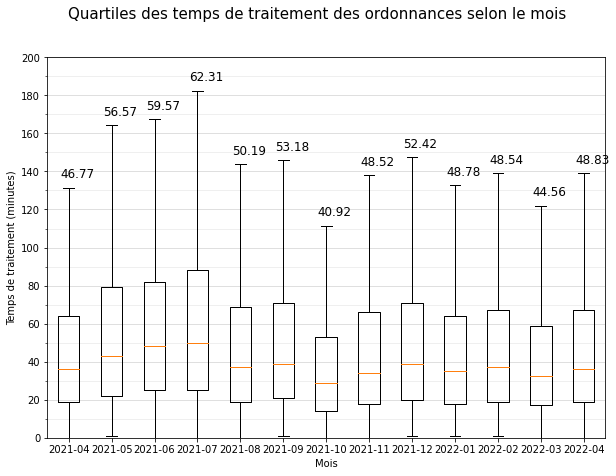

À noter:
Les chiffres représentent les MOYENNES de traitement pour la période donnée.


In [ ]:

fig2 = plt.figure(figsize=(10,7))
#setting axis limit
ax = plt.gca()
ax.set_ylim([0,round((box.max().max()+10)/20)*20])

#setting ticks interval to the next tick up
major_ticks = np.arange(0,round((box.max().max()+10)/20)*20+1,20)
minor_ticks = np.arange(0,round((box.max().max()+10)/20)*20,10)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)

#setting tick thickness
ax.grid(axis = 'y', which='minor', alpha=0.25)
ax.grid(axis = 'y', which='major', alpha=0.5)

plt.xlabel('Mois')
plt.ylabel("Temps de traitement (minutes)")
title2 = "Quartiles des temps de traitement des ordonnances selon le mois"
plt.suptitle(title2, fontsize = 15)
plt.boxplot(box, labels =  box.index);
for i, value in enumerate(graph.Global):
    plt.text(i+0.8,box['max'][i]+5,str(value), size = 'large');

plt.show();
print('À noter:\nLes chiffres représentent les MOYENNES de traitement pour la période donnée.')